In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
import sklearn
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import re
from nltk.corpus import wordnet
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix




# Pre-processing

In [2]:
df = pd.read_excel('/Users/marnixtimmermans/Desktop/Sample_label_good.xlsx')

In [3]:
#Format DF for sentiment analysis using transformers
df = pd.read_excel('/Users/marnixtimmermans/Desktop/Sample_label_good.xlsx')
df = df.reset_index()
df = df[1:]
df = df.rename(columns={'Unnamed: 1': "text",'Unnamed: 2':"label" })

([<matplotlib.patches.Wedge at 0x7ff6e895b370>,
 [Text(0.05664092416031022, 1.198662507009486, '0.0'),
  Text(-0.7023396070602691, -0.8465926271557218, '1.0'),
  Text(0.8788000353886781, -0.6615969300116636, '2.0')],
 [Text(0.03304053909351429, 0.6992197957555335, '48.5%'),
  Text(-0.3830943311237831, -0.46177779663039364, '31.0%'),
  Text(0.47934547384836984, -0.3608710527336347, '20.5%')])

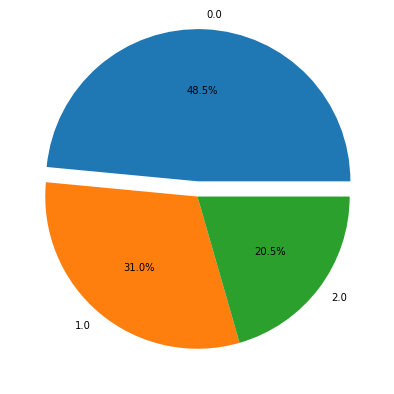

In [5]:
label_distribution = df['label'].value_counts()
plt.figure(figsize =(10, 7))
plt.pie(label_distribution.values, labels = label_distribution.index, explode = (0.1, 0, 0), autopct='%1.1f%%', shadow=False)

In [15]:
#Clean Text
def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^ A-Za-z]+', ' ', text)
    return text

# Cleaning the text in the review column
df['cleaned_text'] = df['text'].apply(clean)
df.head()

,index,Sample_label,text,label,cleaned_text
1,1,449,Neymar one of three PSG stars to test positive...,0.0,Neymar one of three PSG stars to test positive...
2,2,552,[ANNIVERSARY SPECIAL] News industry urged to a...,1.0,ANNIVERSARY SPECIAL News industry urged to a...
3,3,201,"Moon govt. performs best in health, welfare se...",2.0,Moon govt performs best in health welfare se...
4,4,234,Seoul stocks extend winning streak to 5th session,2.0,Seoul stocks extend winning streak to th session
5,5,602,"S. Korea, China agree to seek joint measures i...",2.0,S Korea China agree to seek joint measures i...


In [16]:
# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

df['POS tagged'] = df['cleaned_text'].apply(token_stop_pos)
df.head()

,index,Sample_label,text,label,cleaned_text,POS tagged
1,1,449,Neymar one of three PSG stars to test positive...,0.0,Neymar one of three PSG stars to test positive...,"[(Neymar, n), (one, None), (three, None), (PSG..."
2,2,552,[ANNIVERSARY SPECIAL] News industry urged to a...,1.0,ANNIVERSARY SPECIAL News industry urged to a...,"[(ANNIVERSARY, n), (SPECIAL, n), (News, n), (i..."
3,3,201,"Moon govt. performs best in health, welfare se...",2.0,Moon govt performs best in health welfare se...,"[(Moon, n), (govt, n), (performs, n), (best, r..."
4,4,234,Seoul stocks extend winning streak to 5th session,2.0,Seoul stocks extend winning streak to th session,"[(Seoul, a), (stocks, n), (extend, v), (winnin..."
5,5,602,"S. Korea, China agree to seek joint measures i...",2.0,S Korea China agree to seek joint measures i...,"[(Korea, n), (China, n), (agree, v), (seek, v)..."


In [17]:
#Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos = pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

df['text'] = df['POS tagged'].apply(lemmatize)
df.head()

,index,Sample_label,text,label,cleaned_text,POS tagged
1,1,449,Neymar one three PSG star test positive COVID,0.0,Neymar one of three PSG stars to test positive...,"[(Neymar, n), (one, None), (three, None), (PSG..."
2,2,552,ANNIVERSARY SPECIAL News industry urge adopt...,1.0,ANNIVERSARY SPECIAL News industry urged to a...,"[(ANNIVERSARY, n), (SPECIAL, n), (News, n), (i..."
3,3,201,Moon govt performs best health welfare secto...,2.0,Moon govt performs best in health welfare se...,"[(Moon, n), (govt, n), (performs, n), (best, r..."
4,4,234,Seoul stock extend win streak th session,2.0,Seoul stocks extend winning streak to th session,"[(Seoul, a), (stocks, n), (extend, v), (winnin..."
5,5,602,Korea China agree seek joint measure reduce ...,2.0,S Korea China agree to seek joint measures i...,"[(Korea, n), (China, n), (agree, v), (seek, v)..."


In [18]:
#Create dataframes for each algorithm
df_textblob = df 
df_vader = df
df_sentiwordnet = df

In [19]:
df_sentiwordnet

,index,Sample_label,text,label,cleaned_text,POS tagged
1,1,449,Neymar one three PSG star test positive COVID,0.0,Neymar one of three PSG stars to test positive...,"[(Neymar, n), (one, None), (three, None), (PSG..."
2,2,552,ANNIVERSARY SPECIAL News industry urge adopt...,1.0,ANNIVERSARY SPECIAL News industry urged to a...,"[(ANNIVERSARY, n), (SPECIAL, n), (News, n), (i..."
3,3,201,Moon govt performs best health welfare secto...,2.0,Moon govt performs best in health welfare se...,"[(Moon, n), (govt, n), (performs, n), (best, r..."
4,4,234,Seoul stock extend win streak th session,2.0,Seoul stocks extend winning streak to th session,"[(Seoul, a), (stocks, n), (extend, v), (winnin..."
5,5,602,Korea China agree seek joint measure reduce ...,2.0,S Korea China agree to seek joint measures i...,"[(Korea, n), (China, n), (agree, v), (seek, v)..."
...,...,...,...,...,...,...
996,996,514,U N appeal billion fight coronavirus poor co...,2.0,U N appeals for billion to fight coronaviru...,"[(U, n), (N, n), (appeals, n), (billion, None)..."
997,997,878,World poverty rate mark st rise yr due virus UN,0.0,World poverty rate to mark st rise in yrs d...,"[(World, n), (poverty, n), (rate, n), (mark, v..."
998,998,889,Funky amphibian exhibition wow educate visit...,1.0,Funky amphibian exhibition wows educates visi...,"[(Funky, n), (amphibian, a), (exhibition, n), ..."
999,999,1297,Japan PM Suga vow secure vaccine hope rise b...,2.0,Japan PM Suga vows to secure vaccines as hopes...,"[(Japan, n), (PM, n), (Suga, n), (vows, v), (s..."


# DistilBert

In [20]:
#Apply Distilbert model
from transformers import pipeline

sentiment_analysis = pipeline("sentiment-analysis")

results = []

for i in range(len(df)):
    result = sentiment_analysis(df['text'].iloc[i])[0]
    results.append(result['label'])
#     print(result)
df['results'] = results
df = df.dropna()
df = df[df.label != 1]
df.label = df.label.map({0: 0, 2: 1}).astype(int)
df.results = df.results.replace({'NEGATIVE': 0, 'POSITIVE': 1})


#Calculate accuracy score
# print('accuracy score:', accuracy_score(df.label, df.results))
# print('f1 score:', f1_score(df.label, df.results))
# print('precision score:', precision_score(df.label, df.results, average='binary'))
# print('precision score:', precision_score(df.label, df.results))
# print('recall score:', recall_score(df.label, df.results, average='micro'))
# print('recall score:', recall_score(df.label, df.results))
# print('precision, recall, f1 score:', precision_recall_fscore_support(df.label, df.results, average='micro'))
# print(confusion_matrix(df.label, df.results))

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [21]:
#Calculate accuracy score
print('accuracy score:', accuracy_score(df.label, df.results))
print('precision, recall, f1 score:', precision_recall_fscore_support(df.label, df.results, average='weighted'))
print(confusion_matrix(df.label, df.results))

accuracy score: 0.8113207547169812
precision, recall, f1 score: (0.8051296364682543, 0.8113207547169812, 0.8056226310578491, None)
[[437  47]
 [ 83 122]]


In [ ]:
df['text'].head(0)

# Textblob

In [ ]:
from textblob import TextBlob
# function to calculate subjectivity

def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    else:
        return 'Positive'

In [ ]:
df_textblob = df_textblob.dropna()
df_textblob['TextBlob Polarity'] = df_textblob['text'].apply(getPolarity) 
df_textblob['results'] = df_textblob['TextBlob Polarity'].apply(analysis)
df_textblob = df_textblob[df_textblob.label != 1]
df_textblob.label = df_textblob.label.map({0: 0, 2: 1})
df_textblob.results = df_textblob.results.replace({'Negative': 0, 'Positive': 1})

In [ ]:
df_textblob.head(15)

In [ ]:
#Calculate accuracy score
print('accuracy score:', accuracy_score(df_textblob.label, df_textblob.results))
print('precision, recall, f1 score:', precision_recall_fscore_support(df_textblob.label, df_textblob.results, average='weighted'))
print(confusion_matrix(df_textblob.label, df_textblob.results))

# SentiwordNet

In [ ]:
def sentiwordnetanalysis(pos_data):
    sentiment = 0
    tokens_count = 0
    for word, pos in pos_data:
        if not pos:
            continue
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        if not lemma:
            continue
        
        synsets = wordnet.synsets(lemma, pos=pos)
        if not synsets:
            continue

        # Take the first sense, the most common
        synset = synsets[0]
        print(synsets)
        print(synset)
        swn_synset = swn.senti_synset(synset.name())
        print(swn_synset)
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        tokens_count += 1
        print(swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score())
        
    if not tokens_count:
        return 0
    if sentiment>0:
        return "Positive"
#         return sentiment
    else:
#         return sentiment
        return "Negative"

df_sentiwordnet['SWN analysis'] = df_sentiwordnet['POS tagged'].apply(sentiwordnetanalysis)
df_sentiwordnet = df_sentiwordnet[df_sentiwordnet['SWN analysis'] != 0]
print(df_sentiwordnet['SWN analysis'].value_counts())


df_sentiwordnet = df_sentiwordnet.dropna()
df_sentiwordnet['results'] = df_sentiwordnet['POS tagged'].apply(sentiwordnetanalysis)
df_sentiwordnet = df_sentiwordnet[df_sentiwordnet.label != 1]
df_sentiwordnet.label = df_sentiwordnet.label.map({0: 0, 2: 1})
df_sentiwordnet.results = df_sentiwordnet.results.replace({'Negative': 0, 'Positive': 1})

In [ ]:
df_sentiwordnet.head(15)

In [ ]:
#Calculate accuracy score
print('accuracy score:', accuracy_score(df_sentiwordnet.label, df_sentiwordnet.results))
print('precision, recall, f1 score:', precision_recall_fscore_support(df_sentiwordnet.label, df_sentiwordnet.results, average='weighted'))
print(confusion_matrix(df_sentiwordnet.label, df_sentiwordnet.results))

In [ ]:
swn_counts= df_sentiwordnet['SWN analysis'].value_counts()
plt.figure(figsize=(10, 7))
plt.pie(swn_counts.values, labels = swn_counts.index, explode = (0.1, 0), autopct='%1.1f%%', shadow=False)

In [ ]:
swn_counts.value_counts()

# VADER Sentiment

In [9]:
analyzer = SentimentIntensityAnalyzer()
# function to calculate father sentiment
def father_sentiment_analysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

df_vader['Father Sentiment'] = df_vader['text'].apply(father_sentiment_analysis)
# function to analyse
def vader_analysis(compound):
    if compound > 0:
        return 'Positive'
    else:
        return 'Negative'
    
df_vader = df_vader.dropna()
df_vader['results'] = df_vader['Father Sentiment'].apply(vader_analysis)
df_vader = df_vader[df_vader.label != 1]
df_vader.label = df_vader.label.map({0: 0, 2: 1})
df_vader.results = df_vader.results.replace({'Negative': 0, 'Positive': 1})

In [10]:
#Calculate accuracy score
print('accuracy score:', accuracy_score(df_vader.label, df_vader.results))
print('precision, recall, f1 score:', precision_recall_fscore_support(df_vader.label, df_vader.results, average='weighted'))
print(confusion_matrix(df_vader.label, df_vader.results))


accuracy score: 0.5849056603773585
precision, recall, f1 score: (0.7393892029595949, 0.5849056603773585, 0.5957473089479441, None)
[[229 255]
 [ 31 174]]


In [ ]:
df_sentiwordnet.results.value_counts()

In [ ]:
from nltk.corpus import wordnet
syn = wordnet.synsets('infected')[0]
  
print ("Synset name :  ", syn.name())
  
# Defining the word
print ("\nSynset meaning : ", syn.definition())
  
# list of phrases that use the word in context
print ("\nSynset example : ", syn.examples())
